In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import heapq # for minimum spanning tree
import pickle # for saving the data
import os
import itertools

In [2]:
# from Prof. Jose's code with a few edits
def returns_to_covar(returns, skips):
    num_col = skips
    test = np.zeros(shape = (num_col, num_col))
    threshold = 0.1
    returns[returns == 0] = np.nan
    
    for i, j in list(itertools.combinations(np.arange(num_col), 2)):
        row_mask = (~np.isnan(returns[:, i]))&(~np.isnan(returns[:, j]))
        fraction_included = np.sum(row_mask) / len(returns)
        
        if fraction_included < threshold: 
            test[i, j] = 0
            print(i, j, np.sum(row_mask), len(returns))
        else:
            pi = returns[:, i][row_mask]
            pj = returns[:, j][row_mask]
            test[i, j] = np.sum((pi - np.mean(pi))*(pj - np.mean(pj)))/len(pi)
            # print(i, j)
    
    # test = np.where(test, test, test.T)
    for i in range(num_col):
        row_mask = (~np.isnan(returns[:, i]))
        fraction_included = np.sum(row_mask) / len(returns)
        if fraction_included < threshold: 
            test[i, i] = np.nan
        else:
            test[i, i] = np.nanstd(returns[:, i])**2
     
    nan_rows = np.isnan(test).any(axis=1)
    nan_cols = np.isnan(test).any(axis=0)
    keep_rows = ~nan_rows
    keep_cols = ~nan_cols
    
    arr_cleaned = test[keep_rows][:, keep_cols]
    arr_cleaned = np.where(arr_cleaned, arr_cleaned, arr_cleaned.T)

    return arr_cleaned


# from: https://gist.github.com/wiso/ce2a9919ded228838703c1c7c7dad13b
def covar_to_correl(cov_matrix):
    std_devs = np.sqrt(np.diag(cov_matrix))
    outer_v = np.outer(std_devs, std_devs)
    correlation = cov_matrix / outer_v
    correlation[cov_matrix == 0] = 0
    return correlation

# from: https://stackoverflow.com/questions/42908334/checking-if-a-matrix-is-symmetric-in-numpy
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

# def check_symmetric(a, tol=1e-8):
#     return np.allclose(np.abs(a-a.T) < tol)

# def check_symmetric(a, tol=1e-8):
#     return np.allclose(a, a.T, atol=tol)

# def check_symmetric_approx(a):
#     return np.allclose(a, a.T)

## own dataframe

In [3]:
test_df = pd.DataFrame({
    'a':[1, 2, 3, 4, 5, 6, 6, 5, 4, 3, 2, 1, 2, 2, 2, 2, 2, 2],
    'b':[1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6],
    'c':[np.nan, 1, 9, np.nan, 1, 9, np.nan, 1, 9, np.nan, 1, 9, np.nan, 1, 9, np.nan, 1, 9]
},
    index=pd.date_range(20200601, periods=18, freq='d')
)
test_arr = test_df.to_numpy()
test_arr

array([[ 1.,  1., nan],
       [ 2.,  2.,  1.],
       [ 3.,  3.,  9.],
       [ 4.,  4., nan],
       [ 5.,  5.,  1.],
       [ 6.,  6.,  9.],
       [ 6.,  1., nan],
       [ 5.,  2.,  1.],
       [ 4.,  3.,  9.],
       [ 3.,  4., nan],
       [ 2.,  5.,  1.],
       [ 1.,  6.,  9.],
       [ 2.,  1., nan],
       [ 2.,  2.,  1.],
       [ 2.,  3.,  9.],
       [ 2.,  4., nan],
       [ 2.,  5.,  1.],
       [ 2.,  6.,  9.]])

In [4]:
skips = len(test_df.columns)
window = 4
counter = 0

for i in range(len(test_df.index)):
    # this is to get the matrix
    returns = test_arr[i:i+window]

    # this is to get the covar matrix
    covar_matrix = returns_to_covar(returns, skips)
    counter += 1
    # print(f"Covar matrix:\n{covar_matrix}")
    
    # this is to get the correl matrix
    correl_matrix = covar_to_correl(covar_matrix)
    # print(f"Correl matrix:\n{correl_matrix}")
    
    # this is to get the distance matrix
    distance_matrix = 1 - np.square(correl_matrix)
    # print(f"Distance matrix:\n{distance_matrix}")

    matrices = [covar_matrix, correl_matrix, distance_matrix]
    for matrix in matrices:
        if check_symmetric(matrix) == False:
            print("This matrix is not symmetrical.")
            print(counter)

/tmp/ipykernel_7834/1493646396.py:45: RuntimeWarning: invalid value encountered in divide
  correlation = cov_matrix / outer_v


In [5]:
# skips = len(test_df.columns)
# window = 55

# for i in range(len(test_df.index)):
#     # this is to get the matrix
#     returns = test_arr[i:i+window]

#     # this is to get the covar matrix
#     covar_matrix = returns_to_covar(returns)
#     print(covar_matrix)
    
#     # this is to make the correlation matrix 
#     correl_matrix = covar_to_correl(covar_matrix) 
    
#     # this is to make the distance matrix
#     distance_matrix = 1 - np.square(correl_matrix)

#     # this is to save it into a pickle file
#     tables = {"covariance matrix": covar1, 
#               "correlation matrix": correl_matrix, 
#               "distance matrix": distance_matrix}
    
#     # folder_path = "matrices"
#     # name = covar1.index.get_level_values("date_id").unique().to_list()[0].strftime("%Y-%m-%d")
#     # file_path = os.path.join(folder_path, f"{name}.pickl")

#     # pd.to_pickle(tables, file_path)

## 3 stocks in the PSE

In [6]:
PSE_data = pd.read_csv(
    "daily.csv"
)
PSE_data['date_id'] = pd.to_datetime(PSE_data['date_id'])
PSE_data = PSE_data.set_index("date_id")
df_filtered = PSE_data.drop(columns=[col for col in PSE_data.columns if not (col.startswith('PH_') and col.endswith('_P')) and col != 'date_id'])

df_filtered = df_filtered.loc['2013-06-25':'2023-09-26']

def has_high_null_percentage(column, null_threshold):
    return column.isnull().mean() > null_threshold

null_percentage_threshold = round(df_filtered.shape[0] * 0.85)
columns_to_drop = []

for col in df_filtered.columns:
    if col == "date_id":  
        continue
    if has_high_null_percentage(df_filtered[col], null_percentage_threshold):
        columns_to_drop.append(col)

df_filtered = df_filtered.drop(columns=columns_to_drop)

PSE_log_returns = df_filtered.copy()
numeric_cols = PSE_log_returns.columns.difference(["date_id"])
PSE_log_returns[numeric_cols] = PSE_log_returns[numeric_cols].replace(0, np.nan)
PSE_log_returns[numeric_cols] = np.log(PSE_log_returns[numeric_cols] / PSE_log_returns[numeric_cols].shift(1))

PSE_log_returns = PSE_log_returns.loc['2013-06-26':'2023-09-26']
PSE_log_returns.columns = PSE_log_returns.columns.str.replace(r"_P", "").str.replace(r"PH_", "")

# this was for testing
least_null_cols = PSE_log_returns.isna().sum().nsmallest(3).index
trial = PSE_log_returns[least_null_cols]
trial

,ASA,ABS,AGN
date_id,,,
2013-06-26,0.154151,0.026668,0.182322
2013-06-27,0.000000,0.025975,0.000000
2013-06-28,0.000000,-0.025975,0.000000
2013-07-01,0.000000,0.051293,0.000000
2013-07-02,0.000000,0.000000,0.000000
...,...,...,...
2023-09-20,0.000000,0.000000,0.000000
2023-09-21,0.000000,0.000000,0.000000
2023-09-22,0.000000,0.000000,0.000000


In [7]:
trial_returns = trial.copy()
PSE_log_returns = trial.to_numpy()

In [8]:
skips = len(trial_returns.columns)
window = 110
counter = 0

for i in range(len(trial_returns.index)):
    # this is to get the matrix
    returns = PSE_log_returns[i:i+window]

    # this is to get the covar matrix
    covar_matrix = returns_to_covar(returns, skips)
    counter += 1
    # print(f"Covar matrix:\n{covar_matrix}")
    
    # this is to get the correl matrix
    correl_matrix = covar_to_correl(covar_matrix)
    # print(f"Correl matrix:\n{correl_matrix}")
    
    # this is to get the distance matrix
    distance_matrix = 1 - np.square(correl_matrix)
    # print(f"Distance matrix:\n{distance_matrix}")

    matrices = [covar_matrix, correl_matrix, distance_matrix]
    for matrix in matrices:
        if check_symmetric(matrix) == False:
            print("This matrix is not symmetrical.")
            print(counter)

0 1 2 110
0 2 2 110
1 2 6 110
0 1 1 110
0 2 1 110
1 2 5 110
0 1 1 110
0 2 1 110
1 2 5 110
0 1 1 110
0 2 1 110
1 2 5 110
0 1 1 110
0 2 1 110
1 2 5 110
0 1 1 110
0 2 1 110
1 2 5 110
0 1 1 110
0 2 1 110
1 2 5 110
0 1 1 110
0 2 1 110
1 2 5 110
0 1 1 110
0 2 1 110
1 2 5 110
0 1 1 110
0 2 1 110
1 2 4 110
0 1 1 110
0 2 1 110
1 2 4 110
0 1 1 110
0 2 1 110
1 2 4 110
0 1 1 110
0 2 1 110
1 2 4 110
0 1 1 110
0 2 1 110
1 2 4 110
0 1 1 110
0 2 1 110
1 2 4 110
0 1 1 110
0 2 1 110
1 2 4 110
0 1 1 110
0 2 1 110
1 2 4 110
0 1 1 110
0 2 1 110
1 2 3 110
0 1 1 110
0 2 1 110
1 2 2 110
0 1 1 110
0 2 1 110
1 2 2 110
0 1 1 110
0 2 1 110
1 2 2 110
0 1 1 110
0 2 1 110
1 2 2 110
0 1 1 110
0 2 1 110
1 2 2 110
0 1 1 110
0 2 1 110
1 2 2 110
0 1 1 110
0 2 1 110
1 2 2 110
0 1 1 110
0 2 1 110
1 2 2 110
0 1 1 110
0 2 1 110
1 2 2 110
0 1 1 110
0 2 1 110
1 2 2 110
0 1 1 110
0 2 1 110
1 2 2 110
0 1 1 110
0 2 1 110
1 2 2 110
0 1 1 110
0 2 1 110
1 2 3 110
0 1 1 110
0 2 1 110
1 2 3 110
0 1 1 110
0 2 1 110
1 2 3 110
0 1 1 110


/tmp/ipykernel_7834/1493646396.py:45: RuntimeWarning: invalid value encountered in divide
  correlation = cov_matrix / outer_v


## Gaussian distribution

### This is for a 102 x 3 array

In [9]:
np.random.seed(42)
data = np.random.randn(102, 3)

np.random.seed(42)
nan_mask = np.random.rand(102, 3) < 0.1  # 10% missing values
data[nan_mask] = np.nan
data

array([[ 0.49671415, -0.1382643 ,  0.64768854],
       [ 1.52302986, -0.23415337, -0.23413696],
       [        nan,  0.76743473, -0.46947439],
       [ 0.54256004,         nan, -0.46572975],
       [ 0.24196227, -1.91328024, -1.72491783],
       [-0.56228753, -1.01283112,  0.31424733],
       [-0.90802408, -1.4123037 ,  1.46564877],
       [-0.2257763 ,  0.0675282 , -1.42474819],
       [-0.54438272,  0.11092259, -1.15099358],
       [ 0.37569802, -0.60063869,         nan],
       [-0.60170661,  1.85227818,         nan],
       [-1.05771093,  0.82254491, -1.22084365],
       [ 0.2088636 ,         nan, -1.32818605],
       [ 0.19686124,  0.73846658,  0.17136828],
       [        nan, -0.3011037 , -1.47852199],
       [-0.71984421, -0.46063877,  1.05712223],
       [ 0.34361829, -1.76304016,  0.32408397],
       [-0.38508228, -0.676922  ,  0.61167629],
       [ 1.03099952,  0.93128012,         nan],
       [-0.30921238,         nan,  0.97554513],
       [-0.47917424, -0.18565898, -1.106

In [10]:
skips = 3
window = 10
counter = 0

for i in range(len(data)):
    # this is to get the matrix
    returns = data[i:i+window]

    # this is to get the covar matrix
    covar_matrix = returns_to_covar(returns,skips)
    counter += 1
    # print(f"Covar matrix:\n{covar_matrix}")
    
    # this is to get the correl matrix
    correl_matrix = covar_to_correl(covar_matrix)
    # print(f"Correl matrix:\n{correl_matrix}")
    
    # this is to get the distance matrix
    distance_matrix = 1 - np.square(correl_matrix)
    # print(f"Distance matrix:\n{distance_matrix}")
    
    matrices = [covar_matrix, correl_matrix, distance_matrix]
    for matrix in matrices:
        if check_symmetric(matrix) == False:
            print("This matrix is not symmetrical.")
            print(counter)

/tmp/ipykernel_7834/1493646396.py:45: RuntimeWarning: invalid value encountered in divide
  correlation = cov_matrix / outer_v


Note: I realized that the matrices will only not be symmetrical if the window size is not a multiple of the rows. In example, if you generate a 100-row dataset, but only have a window size of 3, then it will lead to a matrix that is not symmetrical because 100 is not divisible by 3. 

### This is for a 2609 x 300 numpy array

In [11]:
np.random.seed(42)
data = np.random.randn(2609, 300)

np.random.seed(42)
nan_mask = np.random.rand(2609, 300) < 0.1  # 10% missing values
data[nan_mask] = np.nan
data

array([[ 0.49671415, -0.1382643 ,  0.64768854, ...,  0.30729952,
         0.81286212,         nan],
       [        nan, -0.56018104,  0.74729361, ..., -0.97876372,
        -0.44429326,         nan],
       [ 0.75698862, -0.92216532,  0.86960592, ...,  0.14671369,
                nan,         nan],
       ...,
       [ 0.17847475,  0.23949974,  0.37276212, ...,  0.59070092,
         1.09501415, -0.50521937],
       [ 1.14336084,  0.77809928, -1.02127259, ..., -0.01363353,
        -0.230399  , -0.84795407],
       [-1.42741373,  1.57230576,  1.67892859, ...,  0.83199905,
                nan,  0.00707005]])

In [12]:
# skips = 300 # should be the number of columns
# window = 110
# counter = 0

# for i in range(len(data)):
#     # this is to get the matrix
#     returns = data[i:i+window]

#     # this is to get the covar matrix
#     covar_matrix = returns_to_covar(returns)
#     counter += 1
#     # print(f"Covar matrix:\n{covar_matrix}")
    
#     # this is to get the correl matrix
#     correl_matrix = covar_to_correl(covar_matrix)
#     # print(f"Correl matrix:\n{correl_matrix}")
    
#     # this is to get the distance matrix
#     distance_matrix = 1 - np.square(correl_matrix)
#     # print(f"Distance matrix:\n{distance_matrix}")
    
#     matrices = [covar_matrix, correl_matrix, distance_matrix]
#     for matrix in matrices:
#         if check_symmetric(matrix) == False:
#             print(f"{matrix} is not symmetrical.")
#             print(counter)

## all stocks in the PSE

In [13]:
PSE_data = pd.read_csv(
    "daily.csv"
)
PSE_data['date_id'] = pd.to_datetime(PSE_data['date_id'])
PSE_data = PSE_data.set_index("date_id")
df_filtered = PSE_data.drop(columns=[col for col in PSE_data.columns if not (col.startswith('PH_') and col.endswith('_P')) and col != 'date_id'])

df_filtered = df_filtered.loc['2013-06-25':'2023-09-26']

def has_high_null_percentage(column, null_threshold):
    return column.isnull().mean() > null_threshold

null_percentage_threshold = round(df_filtered.shape[0] * 0.85)
columns_to_drop = []

for col in df_filtered.columns:
    if col == "date_id":  
        continue
    if has_high_null_percentage(df_filtered[col], null_percentage_threshold):
        columns_to_drop.append(col)

df_filtered = df_filtered.drop(columns=columns_to_drop)

PSE_log_returns = df_filtered.copy()
numeric_cols = PSE_log_returns.columns.difference(["date_id"])
PSE_log_returns[numeric_cols] = PSE_log_returns[numeric_cols].replace(0, np.nan)    
PSE_log_returns[numeric_cols] = np.log(PSE_log_returns[numeric_cols] / PSE_log_returns[numeric_cols].shift(1))

PSE_log_returns = PSE_log_returns.loc['2013-06-26':'2023-09-26']
PSE_log_returns.columns = PSE_log_returns.columns.str.replace(r"_P", "").str.replace(r"PH_", "")

print(PSE_log_returns.iloc[1000])
returns_df = PSE_log_returns.copy()
PSE_log_returns = PSE_log_returns.to_numpy()

PHIP    NaN
ASA     0.0
ABS     0.0
AGN     0.0
APC     0.0
       ... 
H2O     0.0
PHRC    0.0
SSN     0.0
SIN     0.0
SHK     0.0
Name: 2017-04-26 00:00:00, Length: 294, dtype: float64


In [14]:
# skips = len(returns_df.columns)
# window = 110
# counter = 0

# for i in range(len(returns_df.index)):
#     # this is to get the matrix
#     returns = PSE_log_returns[i:i+window]

#     # this is to get the covar matrix
#     covar_matrix = returns_to_covar(returns)
#     counter += 1
#     # print(f"Covar matrix:\n{covar_matrix}")
    
#     # this is to get the correl matrix
#     correl_matrix = covar_to_correl(covar_matrix)
#     # print(f"Correl matrix:\n{correl_matrix}")
    
#     # this is to get the distance matrix
#     distance_matrix = 1 - np.square(correl_matrix)
#     # print(f"Distance matrix:\n{distance_matrix}")
    
#     matrices = [covar_matrix, correl_matrix, distance_matrix]
#     for matrix in matrices:
#         # if check_symmetric(matrix) == True:
#         #     print("This matrix is symmetrical.")
#         #     print(counter)
        
#         if check_symmetric(matrix) == False:
#             print("This matrix is not symmetrical.")
#             symmetry = np.max(np.abs(matrix - matrix.T))
#             print(f"{symmetry:.100f}")
#             print(counter)

In [15]:
skips = len(returns_df.columns)
window = 110
counter = 0
i = 2000

returns = PSE_log_returns[i:i+window]
returns = np.array(returns, dtype=np.float64)
print(f"Returns matrix:\n{returns}")

# this is to get the covar matrix
covar_matrix = returns_to_covar(returns, skips)
counter += 1
covar_matrix = np.array(covar_matrix, dtype=np.float64)
print(f"Covar matrix:\n{covar_matrix}")
    
# this is to get the correl matrix
correl_matrix = covar_to_correl(covar_matrix)
correl_matrix = np.nan_to_num(correl_matrix, nan=0, posinf=1, neginf=-1)
correl_matrix = np.clip(correl_matrix, -1, 1)
correl_matrix = np.array(correl_matrix, dtype=np.float64)
print(f"Correl matrix:\n{correl_matrix}")
    
# this is to get the distance matrix
distance_matrix = 1 - np.square(correl_matrix)
distance_matrix = np.array(distance_matrix, dtype=np.float64)
print(f"Distance matrix:\n{distance_matrix}")
    
matrices = [covar_matrix, correl_matrix, distance_matrix]
for matrix in matrices:
    if check_symmetric(matrix) == True:
        print("This matrix is symmetrical.")
        # symmetry = np.max(np.abs(matrix - matrix.T))
        # print(f"{symmetry:.100f}")
        # print(counter)
    if check_symmetric(matrix) == False:
        print("This matrix is not symmetrical.")
        symmetry = np.max(np.abs(matrix - matrix.T))
        print(f"{symmetry:.100f}")
        # print(counter)

Returns matrix:
[[nan  0.  0. ...  0. nan  0.]
 [nan  0.  0. ...  0. nan  0.]
 [nan  0.  0. ...  0. nan  0.]
 ...
 [nan  0.  0. ...  0. nan  0.]
 [nan  0.  0. ...  0. nan  0.]
 [nan  0.  0. ...  0. nan  0.]]
0 1 0 110
0 2 0 110
0 3 0 110
0 4 0 110
0 5 0 110
0 6 0 110
0 7 0 110
0 8 0 110
0 9 0 110
0 10 0 110
0 11 0 110
0 12 0 110
0 13 0 110
0 14 0 110
0 15 0 110
0 16 0 110
0 17 0 110
0 18 0 110
0 19 0 110
0 20 0 110
0 21 0 110
0 22 0 110
0 23 0 110
0 24 0 110
0 25 0 110
0 26 0 110
0 27 0 110
0 28 0 110
0 29 0 110
0 30 0 110
0 31 0 110
0 32 0 110
0 33 0 110
0 34 0 110
0 35 0 110
0 36 0 110
0 37 0 110
0 38 0 110
0 39 0 110
0 40 0 110
0 41 0 110
0 42 0 110
0 43 0 110
0 44 0 110
0 45 0 110
0 46 0 110
0 47 0 110
0 48 0 110
0 49 0 110
0 50 0 110
0 51 0 110
0 52 0 110
0 53 0 110
0 54 0 110
0 55 0 110
0 56 0 110
0 57 0 110
0 58 0 110
0 59 0 110
0 60 0 110
0 61 0 110
0 62 0 110
0 63 0 110
0 64 0 110
0 65 0 110
0 66 0 110
0 67 0 110
0 68 0 110
0 69 0 110
0 70 0 110
0 71 0 110
0 72 0 110
0 73 0 11

# tests on diagonals

In [16]:
# def check_diagonals(matrix, target_value):
#     for i in range(len(matrix)):
#         for j in range(len(matrix[0])):
#             if i == j and matrix[i][j] != target_value:
#                 print(f"Diagonal has a weird value here{[i, j]}")

def check_diagonals(matrix, target_value):
    for i in range(min(len(matrix), len(matrix[0]))):
        if matrix[i][i] != target_value:
            print(f"Diagonal has a weird value at index {i, i}: {matrix[i][i]}")

In [17]:
print(PSE_log_returns[1000:1100])
print(returns)

[[nan  0.  0. ...  0.  0.  0.]
 [nan  0.  0. ...  0.  0.  0.]
 [nan  0.  0. ...  0.  0.  0.]
 ...
 [nan  0.  0. ...  0.  0.  0.]
 [nan  0.  0. ...  0.  0.  0.]
 [nan  0.  0. ...  0.  0.  0.]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [36]:
print(df_filtered[2000:2110])
print(covar_matrix[:5, :5])

            PH_PIP_P  PH_ASA_P  PH_ABS_P  PH_AGN_P  PH_APC_P  PH_CHP_P  \
date_id                                                                  
2021-02-23       NaN       7.0      12.0       7.0       0.0       1.0   
2021-02-24       NaN       7.0      12.0       7.0       0.0       1.0   
2021-02-25       NaN       7.0      12.0       7.0       0.0       1.0   
2021-02-26       NaN       7.0      12.0       7.0       0.0       1.0   
2021-03-01       NaN       7.0      13.0       7.0       0.0       1.0   
...              ...       ...       ...       ...       ...       ...   
2021-07-20       NaN       7.0      12.0       6.0       0.0       1.0   
2021-07-21       NaN       7.0      11.0       6.0       0.0       1.0   
2021-07-22       NaN       7.0      11.0       6.0       0.0       1.0   
2021-07-23       NaN       7.0      11.0       6.0       0.0       1.0   
2021-07-26       NaN       7.0      11.0       6.0       0.0       1.0   

            PH_CEU_P  PH_CIR_P  PH_CA

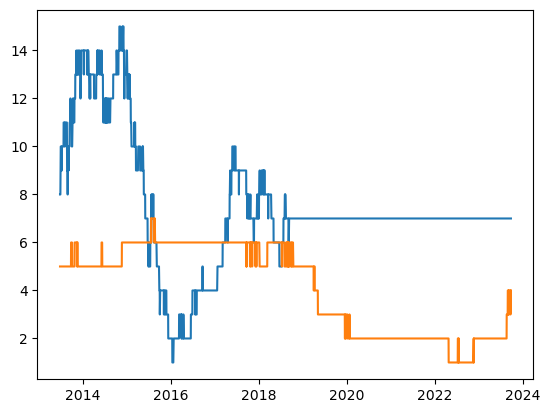

In [44]:
plt.plot(df_filtered["PH_MRP_P"])
plt.plot(df_filtered["PH_LOT_P"])

In [18]:
check_diagonals(covar_matrix, 0)

Diagonal has a weird value at index (0, 0): 0.007372603010243215
Diagonal has a weird value at index (1, 1): 0.032151309536222035
Diagonal has a weird value at index (2, 2): 0.0022163749048496285
Diagonal has a weird value at index (3, 3): 0.017356182187365406
Diagonal has a weird value at index (4, 4): 0.0013387428997764935
Diagonal has a weird value at index (5, 5): 0.009877566184365222
Diagonal has a weird value at index (6, 6): 0.00038145790352067384
Diagonal has a weird value at index (7, 7): 0.02968663082905923
Diagonal has a weird value at index (8, 8): 0.0015737576276594208
Diagonal has a weird value at index (9, 9): 0.008841916819508876
Diagonal has a weird value at index (10, 10): 0.4764823278527618
Diagonal has a weird value at index (11, 11): 0.002624500054856086
Diagonal has a weird value at index (12, 12): 0.16440195389316542
Diagonal has a weird value at index (13, 13): 0.00043595505036811357
Diagonal has a weird value at index (14, 14): 0.008092704964727256
Diagonal has

In [19]:
covar_matrix[:5, :5]

array([[0.0073726 , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.03215131, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00221637, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.01735618, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00133874]])

In [20]:
correl_matrix[:5, :5]

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [21]:
PSE_log_returns[1000:1100]

array([[nan,  0.,  0., ...,  0.,  0.,  0.],
       [nan,  0.,  0., ...,  0.,  0.,  0.],
       [nan,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [nan,  0.,  0., ...,  0.,  0.,  0.],
       [nan,  0.,  0., ...,  0.,  0.,  0.],
       [nan,  0.,  0., ...,  0.,  0.,  0.]])

In [22]:
returns[:, 3]

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
       -0.15415068,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

In [23]:
check_diagonals(correl_matrix, 1)

In [24]:
check_diagonals(distance_matrix, 0)

In [25]:
covar_matrix[:4, :4]

array([[0.0073726 , 0.        , 0.        , 0.        ],
       [0.        , 0.03215131, 0.        , 0.        ],
       [0.        , 0.        , 0.00221637, 0.        ],
       [0.        , 0.        , 0.        , 0.01735618]])

In [26]:
correl_matrix[:5, :5]

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [27]:
arr = np.abs(np.random.randn(4, 4))
np.fill_diagonal(arr, 1)
arr[1, 0] = np.nan
arr[3, 2] = np.nan
print("Numpy array:")
print(arr)

nan_rows = np.isnan(arr).any(axis=1)
nan_cols = np.isnan(arr).any(axis=0)
keep_rows = ~nan_rows
keep_cols = ~nan_cols

arr_cleaned = arr[keep_rows][:, keep_cols]

cor = covar_to_correl(arr_cleaned)

print("\nCleaned Numpy array:")
print(arr_cleaned)
print("\nCorrel Numpy array:")
print(cor)

Numpy array:
[[1.         0.41794696 1.50896769 0.64226993]
 [       nan 1.         1.69194339 0.68107137]
 [0.73103097 0.72859697 1.         0.37398228]
 [1.07183327 1.60610234        nan 1.        ]]

Cleaned Numpy array:
[[0.41794696 0.64226993]
 [0.72859697 0.37398228]]

Correl Numpy array:
[[1.         1.62454405]
 [1.84289785 1.        ]]


# numerical tests

In [28]:
covar_matrix[1,2]

0.0

In [29]:
covar_matrix[1,2]/np.sqrt(covar_matrix[1,1] * covar_matrix[2,2])

0.0

In [30]:
correl_matrix[2,1]

0.0

In [31]:
print(covar_matrix[49,50])
print(covar_matrix[49,50]/np.sqrt(covar_matrix[49,49] * covar_matrix[50,50]))
print(correl_matrix[49,50])
print(correl_matrix[50,49])

0.0001369723234453981
0.251315078686234
0.251315078686234
0.251315078686234


In [32]:
print(covar_matrix[1,200])
print(covar_matrix[1,200]/np.sqrt(covar_matrix[1,1] * covar_matrix[200,200]))
print(correl_matrix[200,1])
print(correl_matrix[1,200])

IndexError: index 200 is out of bounds for axis 1 with size 82

In [ ]:
correl_matrix

In [ ]:
correl = np.square(correl_matrix)
correl[1:10, 1:10]

In [ ]:
distance_matrix

In [ ]:
(1 - correl)[1:10, 1:10]

In [ ]:
dist = 1 - correl_matrix
dist[1:10, 1:10]

In [ ]:
returns

In [ ]:
distance_matrix.size

In [ ]:
np.sum(distance_matrix == 1)

In [ ]:
np.sum(distance_matrix == 0)

In [ ]:
arr = np.random.randn(4, 3) 
arr[1, 1] = np.nan
print("Numpy array:") 
print(arr) 
  
# convert numpy array to dataframe 
df = pd.DataFrame(arr) 
df = df.dropna(how='any', axis=0)
print("\nPandas DataFrame:") 
print(df)

print(df.to_numpy())

In [ ]:
arr = np.random.randn(4, 4)
np.fill_diagonal(arr, 1)
arr[1, 0] = np.nan
arr[3, 2] = np.nan
print("Numpy array:")
print(arr)

nan_rows = np.isnan(arr).any(axis=1)
nan_cols = np.isnan(arr).any(axis=0)
keep_rows = ~nan_rows
keep_cols = ~nan_cols

arr_cleaned = arr[keep_rows][:, keep_cols]

print("\nCleaned Numpy array:")
print(arr_cleaned)

In [ ]:
# def returns_to_covar(returns):
#     num_col = skips
#     test = np.zeros(shape = (num_col, num_col))
    
#     for i, j in list(itertools.combinations(np.arange(num_col), 2)):
#         row_mask = (~np.isnan(returns[:, i]))&(~np.isnan(returns[:, j]))
#         fraction_included = np.sum(row_mask) / len(returns)
        
#         if fraction_included < 0.1:
#             test[i, j] = 0
#         else:
#             pi = returns[:, i][row_mask]
#             pj = returns[:, j][row_mask]
#             test[i, j] = np.sum((pi - np.mean(pi))*(pj - np.mean(pj)))/len(pi)
#             # print(i, j)
    
#     test = np.where(test, test, test.T)
#     for i in range(num_col):
#         test[i, i] = np.nanstd(returns[:, i])**2
    
#     # for i in range(num_col):
#     #     for j in range(i + 1, num_col):  # Iterate only over the upper triangle
#     #         test[j, i] = test[i, j]  # Copy the upper triangle to the lower triangle
    
#     nan_rows = np.isnan(test).any(axis=1)
#     nan_cols = np.isnan(test).any(axis=0)
#     keep_rows = ~nan_rows
#     keep_cols = ~nan_cols
    
#     arr_cleaned = arr[keep_rows][:, keep_cols]
    
#     return arr_cleaned